In [1]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform

from tqdm import tqdm

In [94]:
# DATA_DIR = '../../datasets/NNN/unit_data_full.pkl'
DATA_DIR = '../../datasets/NNN/body_roi_data.pkl'
dat = pd.read_pickle(DATA_DIR)
print(f'Sucessfully loaded data for {len(dat)} units!')

Sucessfully loaded data for 7077 units!


In [95]:
rois = list(dat['roi'].unique())
rois

['MB1_3_B',
 'MB2_20_B',
 'Unknown_20_B',
 'Unknown_6_B',
 'MB2_21_B',
 'Unknown_9_B',
 'Unknown_23_B',
 'MB1_8_B',
 'AB3_18_B',
 'MB3_12_B',
 'AB3_12_B',
 'AB3_17_B',
 'Unknown_27_B']

In [4]:
print(f'Range of face selectivities: {np.min(dat['F_SI'])}, {np.max(dat['F_SI'])}')
print(f'Number of significant units (p<0.05): {np.sum(dat['p_value']<0.05)}')

sig_dat = dat[dat['p_value']<0.05]

Range of face selectivities: -3.483745813369751, 5.77348518371582
Number of significant units (p<0.05): 2914


In [ ]:
# ADD P-VALUE AND SAVE SUBSETS DATA

# img_psth = dat['img_psth'].iloc[0]

# ONSET_TIME = 50
# RESPONSE_WIN = slice(ONSET_TIME + 50, ONSET_TIME + 220)
# BASELINE_WIN = slice(ONSET_TIME - 50, ONSET_TIME + 0)

# # baseline normed response to 1072 different images
# normed_response = img_psth[RESPONSE_WIN, 1000:].mean(axis=0) - img_psth[BASELINE_WIN, 1000:].mean(axis=0)

# stats.ttest_rel(img_psth[RESPONSE_WIN, 1000:].mean(axis=0), img_psth[BASELINE_WIN, 1000:].mean(axis=0))
ONSET_TIME = 50
RESP_WIN = slice(ONSET_TIME + 50, ONSET_TIME + 220)
BASE_WIN = slice(ONSET_TIME - 50, ONSET_TIME + 0)
IMG_SLICE = slice(1000, None)

def unit_pvalue(A):
    A = np.asarray(A)
    resp = A[RESP_WIN, IMG_SLICE].mean(axis=0)
    base = A[BASE_WIN, IMG_SLICE].mean(axis=0)

    m = np.isfinite(resp) & np.isfinite(base)
    if m.sum() < 2:
        return np.nan
    return stats.ttest_rel(resp[m], base[m]).pvalue

# dat['p_value'] = [unit_pvalue(A) for A in dat['img_psth']]
# dat.to_pickle(DATA_DIR)

# SAVE_DIR = '../../datasets/NNN/body_roi_data.pkl'

# dat = dat[dat['roi'].astype(str).str.contains('B')]
# dat.to_pickle(SAVE_DIR)

In [ ]:
# PLOT SELECTIVITY DISTRIBUTIONS
fig,ax = plt.subplots(1,1)

sel = 'O_SI'
sns.histplot(dat[sel], ax=ax)
cutoff = np.sqrt(np.var(dat[sel])) * 2
ax.axvline(x=cutoff, color='red')

sns.histplot(sig_dat[sel], ax=ax)
cutoff = np.sqrt(np.var(sig_dat[sel])) * 2
ax.axvline(x=cutoff, color='red', linestyle='dashed')
ax.set_title(sel)

In [ ]:
# PLOT NUMBER OF UNITS UNDER DIFFERENT CONDITIONS (P_VAL, SI, ETC)
# dat[(dat['p_value']>0.05) & (dat['F_SI']>cutoff)]

fig, ax = plt.subplots(1,1)

sizes = [len(dat)]
inc = np.sum(dat['p_value']<0.05)
sizes.append(inc)
for sel in ['F_SI', 'B_SI', 'O_SI']:
    # cutoff based on n standard deviations
    cutoff = np.sqrt(np.var(dat[sel])) * 0.5
    sizes.append(np.sum(dat[sel]>cutoff))
    sizes.append(np.sum((dat['p_value']<0.05) & (dat[sel]>cutoff)))

sns.barplot(sizes, ax=ax)
ax.set_xticklabels(['all', 'p<0.05', 'F_SI', 'F_SI + p', 'B_SI', 'B_SI + p', 'O_SI', 'O_SI + p'])
ax.set_title('Number of units in face ROIs')

In [ ]:
# CALCULATE RDMs FOR SIG UNITS
sig_dat = dat[dat['p_value']<0.05]

def unit_rdm(A):
    z = stats.zscore(A, axis=0, nan_policy='omit')  # z-score each image over time
    z = np.nan_to_num(z)
    return squareform(pdist(z, metric='correlation'))  # distance across images

rdms = []
for i, A in tqdm(enumerate(sig_dat['img_psth'])):
    rdm = unit_rdm(A)                 # one RDM per unit
    rdms.append(rdm)

    if i>100:
        break
rdms = np.array(rdms)
mean_rdm = np.nanmean(rdms, axis=0)                     # average across units

sns.heatmap(mean_rdm, square=True)

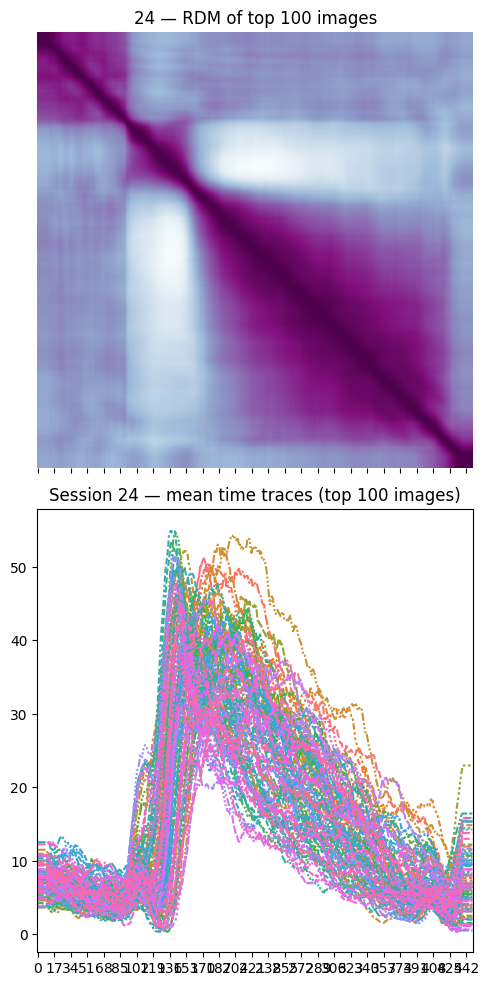

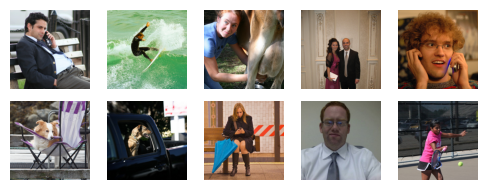

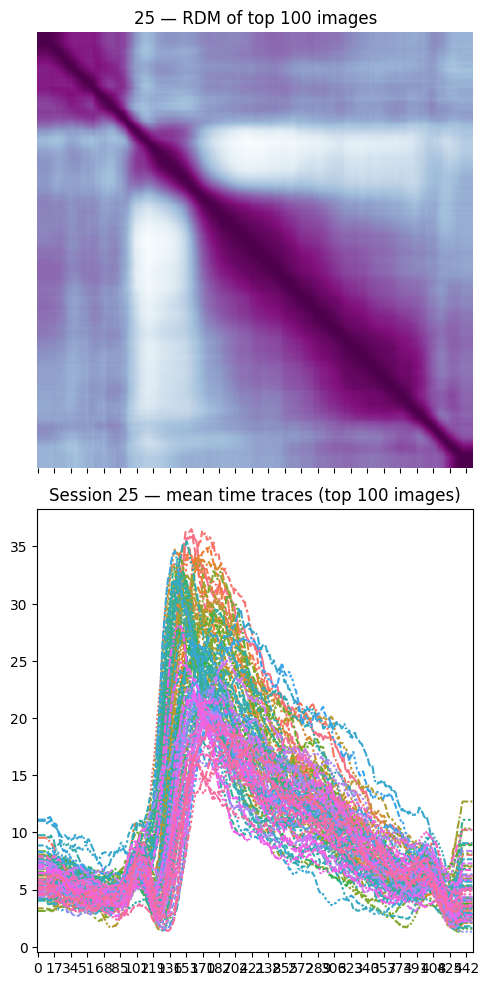

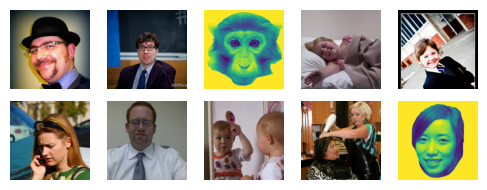

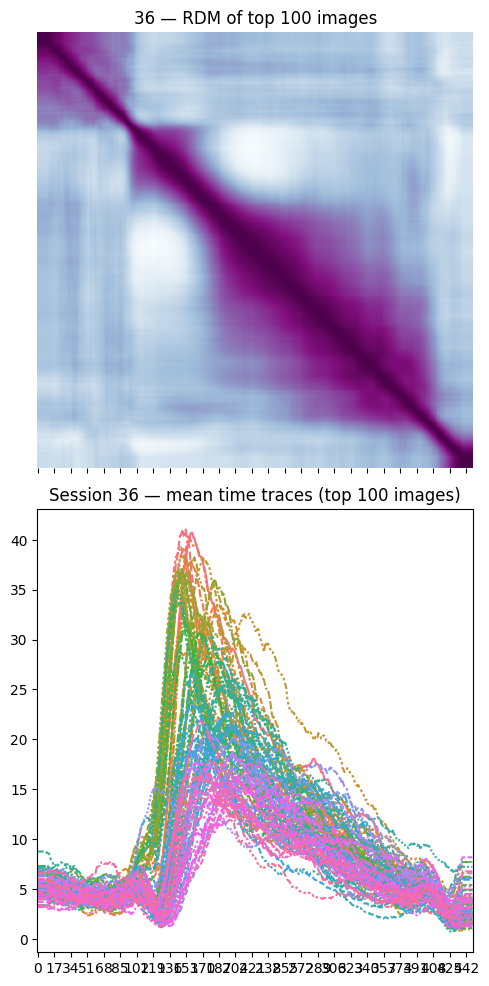

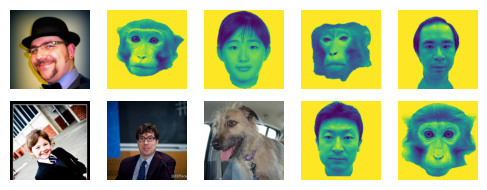

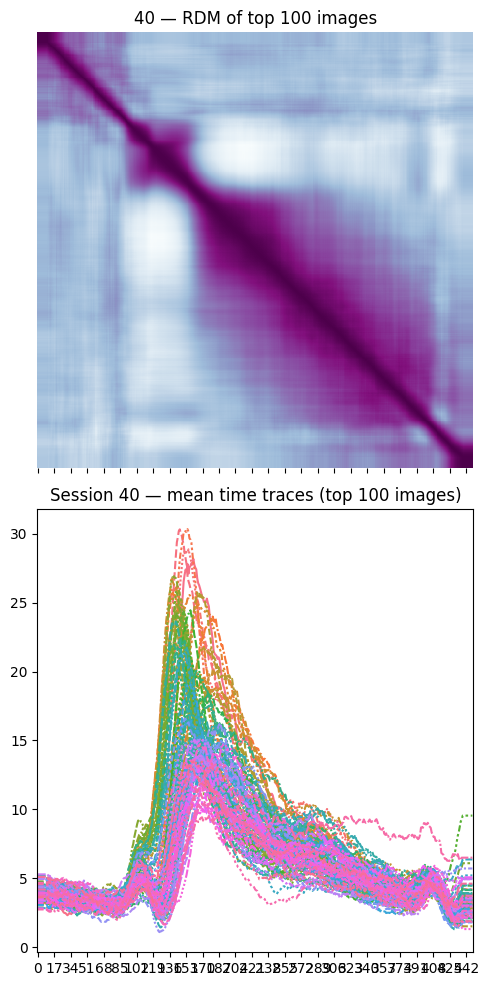

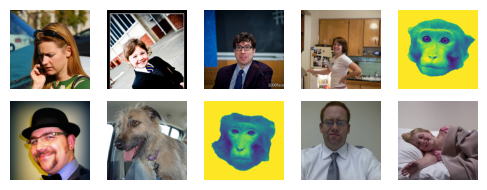

In [38]:
# HEATMAP FOR TIME X TIME, BY TOP_N IMAGES

ROI = 'MF1_8_F' # AO2_24_O, MF1_7_F, MO2_21_O, MB2_20_B, MB1_3_B, AB3_12_B, MB2_20_B
sig_dat = dat[dat['p_value']<0.05]
dynamic_face = sig_dat[sig_dat['roi'] == ROI]

ONSET = 50
RESP = slice(ONSET + 50, ONSET + 220)  # 100:270
BASE = slice(ONSET - 50, ONSET + 0)    #   0:50
TOP_N = 100                        # pick top-N images by response-baseline
IMAGE_DIR = "../../datasets/NNN/NSD1000_LOC"
TOP_SHOW = min(TOP_N, 10)

for session in dynamic_face['session'].unique():
    dfdf = dynamic_face[dynamic_face['session'] == session]
    X = np.array([A for A in dfdf['img_psth']])  # (units, time, images)

    # score each image: mean response (50-220) minus baseline (-50–0), averaged across units
    resp = np.nanmean(X[:, RESP, :], axis=(0, 1))
    base = np.nanmean(X[:, BASE, :], axis=(0, 1))
    scores = resp - base

    # top images by score
    top_iids = np.argsort(scores)
    top_idx = top_iids[-TOP_N:][::-1] # UNCOMMENT FOR TOP_N IMAGES
    # top_idx = np.random.choice(top_iids, TOP_N) # UNCOMMENT FOR RANDOM_IMAGES

    # average timecourse across units for those images
    Xtop = X[:, :, top_idx]                     # (units, time, top_n)
    Xtop_avg = np.nanmean(Xtop, axis=0)         # (time, top_n)

    # RDM across images (correlation distance on (time) features)
    rdm = squareform(pdist(Xtop_avg, metric='correlation'))
    
    fig, axes = plt.subplots(2,1, figsize=(5, 10), sharex=True)
    # heatmap (images × images)
    sns.heatmap(rdm, square=True, ax=axes[0], cmap=sns.color_palette('BuPu_r', as_cmap=True),
                cbar=False, yticklabels=False)
    axes[0].set_title(f"{session} — RDM of top {TOP_N} images")
    
    # lineplot (time × image)
    sns.lineplot(data=Xtop_avg, legend=False, ax=axes[1])
    axes[1].set_xlim(0, Xtop_avg.shape[0])
    axes[1].set_title(f"Session {session} — mean time traces (top {TOP_N} images)")
    
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(2, 5, figsize=(5, 2))
    axes = axes.ravel()

    top10 = top_idx[:TOP_SHOW]
    for ax, idx in zip(axes, top10):
        if idx < 1000:
            fname = f"{idx+1:04d}.bmp"
        else:
            fname = f"MFOB{idx-999:03d}.bmp"  # 1000→MFOB001, 1071→MFOB072
        fpath = os.path.join(IMAGE_DIR, fname)
        if os.path.exists(fpath):
            img = mpimg.imread(fpath)
            ax.imshow(img)
            ax.set_title('')
            ax.axis("off")
        else:
            ax.text(0.5, 0.5, "missing", ha="center", va="center")
            ax.axis("off")
    
    plt.tight_layout()
    plt.show()

In [41]:
# Refactor: choose ROI, top vs shuffled images, grow subset in steps of N, make RDM GIF
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, os
from scipy.spatial.distance import pdist, squareform
from matplotlib.animation import FuncAnimation, PillowWriter

def rdm_gif(dat, ROI, mode='top', step=10, k_max=200, metric='correlation',
            onset=50, resp=(50,220), base=(-50,0), session=None):
    """
    mode: 'top' or 'shuffle'
    step/k_max: grow subset sizes [step, 2*step, ..., k_max]
    session: None=all sessions pooled; or pass a specific session value
    """
    rng = np.random.default_rng(0)
    ONSET = 50
    RESP = slice(ONSET + resp[0], ONSET + resp[1])
    BASE = slice(ONSET + base[0], ONSET + base[1])

    # --- subset data ---
    sig = dat[dat['p_value'] < 0.05]
    roi_df = sig[sig['roi'] == ROI] if session is None else sig[(sig['roi']==ROI) & (sig['session']==session)]
    if len(roi_df) == 0: raise ValueError("No rows for given ROI/session.")
    X = np.stack(roi_df['img_psth'].to_numpy())  # (units, time, images)

    # --- image scores and ordering ---
    resp_mean = np.nanmean(X[:, RESP, :], axis=(0,1))
    base_mean = np.nanmean(X[:, BASE, :], axis=(0,1))
    scores = resp_mean - base_mean
    order = np.argsort(scores)[::-1] if mode == 'top' else rng.permutation(scores.size)

    # --- precompute vmax for consistent color scale ---
    sizes = [k for k in range(step, min(k_max, X.shape[2]) + 1, step)]
    rdms = []
    for k in sizes:
        idx = order[:k]
        Xavg = np.nanmean(X[:, :, idx], axis=0)          # (time, k)
        R = squareform(pdist(Xavg, metric=metric))        # (time, time)
        rdms.append(R)
    vmin, vmax = 0.0, np.nanmax([R.max() for R in rdms])  # lock scale across frames

    # --- animate ---
    fig, ax = plt.subplots(figsize=(5,5))
    hm = sns.heatmap(rdms[0], cmap=sns.color_palette('magma'),
                     vmin=vmin, vmax=vmax, square=True, cbar=False, ax=ax)
    title = ax.set_title(f"{ROI} | {mode} | {metric} | k={sizes[0]}")

    def update(i):
        ax.clear()
        sns.heatmap(rdms[i], cmap=sns.color_palette('magma', as_cmap=True),
                    vmin=vmin, vmax=vmax, square=True, cbar=False, ax=ax)
        ax.set_xticks([]); ax.set_yticks([])
        title = ax.set_title(f"{ROI} | {mode} | {metric} | k={sizes[i]}")
        return [title]

    anim = FuncAnimation(fig, update, frames=len(rdms), interval=400, blit=False)
    
    return anim
    anim.save(outpath, writer=PillowWriter(fps=10))
    plt.close(fig)
    return outpath

  0%|                                                                                                                                                                             | 0/7 [00:00<?, ?it/s]

Saved: <matplotlib.animation.FuncAnimation object at 0x15a4e7b60>


 14%|███████████████████████▌                                                                                                                                             | 1/7 [00:29<02:58, 29.71s/it]

Saved: <matplotlib.animation.FuncAnimation object at 0x15faf8c80>
Saved: <matplotlib.animation.FuncAnimation object at 0x15a4e7b60>


 29%|███████████████████████████████████████████████▏                                                                                                                     | 2/7 [01:00<02:32, 30.53s/it]

Saved: <matplotlib.animation.FuncAnimation object at 0x15a4e7890>
Saved: <matplotlib.animation.FuncAnimation object at 0x15a4e7b60>


 43%|██████████████████████████████████████████████████████████████████████▋                                                                                              | 3/7 [03:01<04:46, 71.55s/it]

Saved: <matplotlib.animation.FuncAnimation object at 0x15a4e7890>
Saved: <matplotlib.animation.FuncAnimation object at 0x15a4e7b60>


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 4/7 [03:38<02:53, 57.96s/it]

Saved: <matplotlib.animation.FuncAnimation object at 0x15a4e7890>
Saved: <matplotlib.animation.FuncAnimation object at 0x15a4e7b60>


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 5/7 [04:10<01:37, 48.64s/it]

Saved: <matplotlib.animation.FuncAnimation object at 0x15a4e7890>
Saved: <matplotlib.animation.FuncAnimation object at 0x15a4e7b60>


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 6/7 [04:32<00:39, 39.72s/it]

Saved: <matplotlib.animation.FuncAnimation object at 0x15a4e7890>
Saved: <matplotlib.animation.FuncAnimation object at 0x15a4e7b60>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:57<00:00, 42.46s/it]

Saved: <matplotlib.animation.FuncAnimation object at 0x15a4e7890>


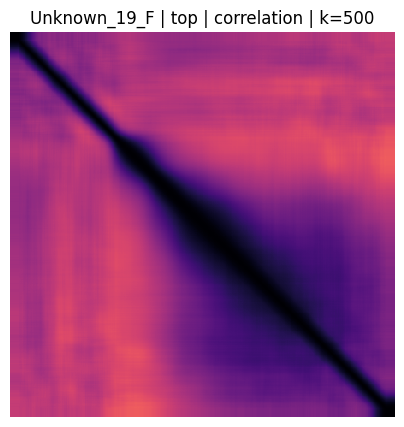

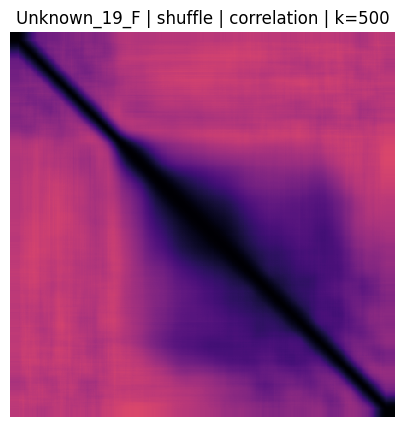

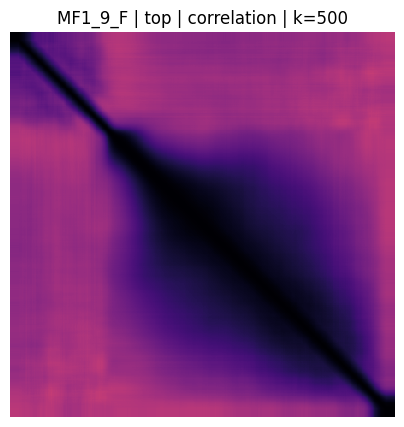

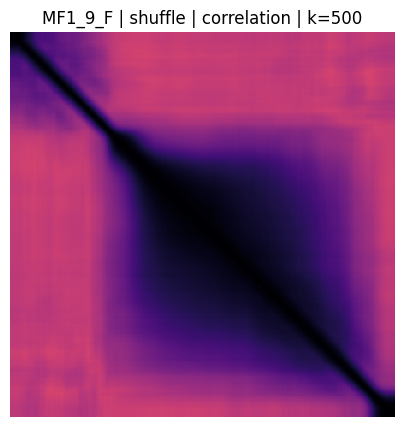

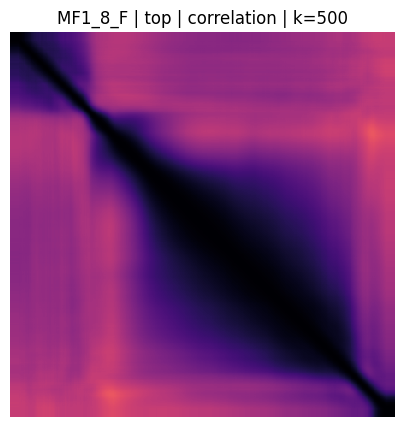

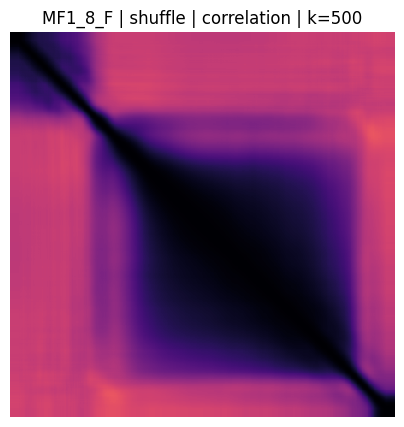

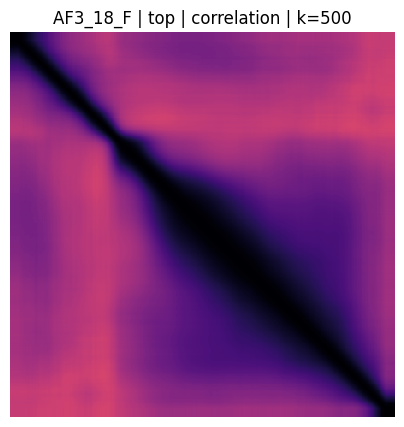

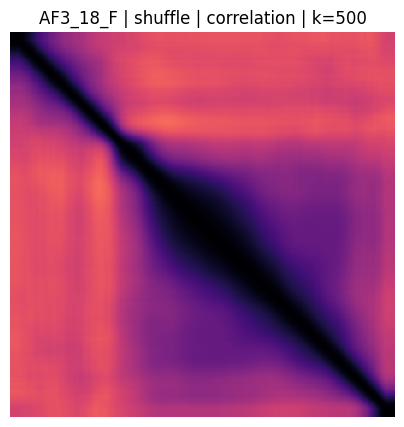

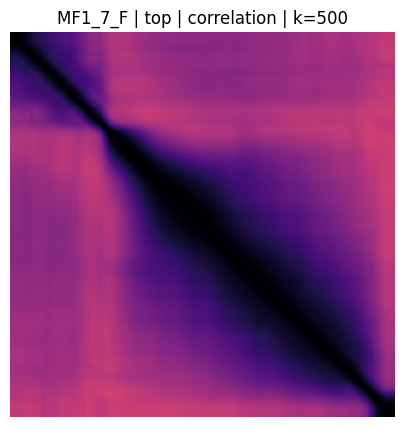

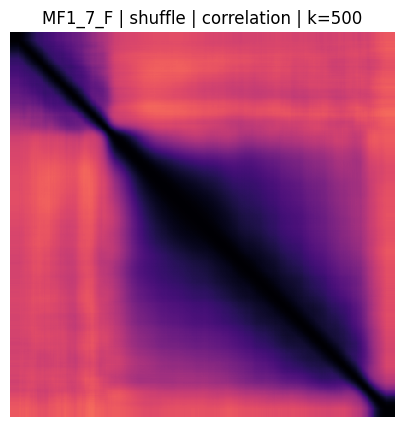

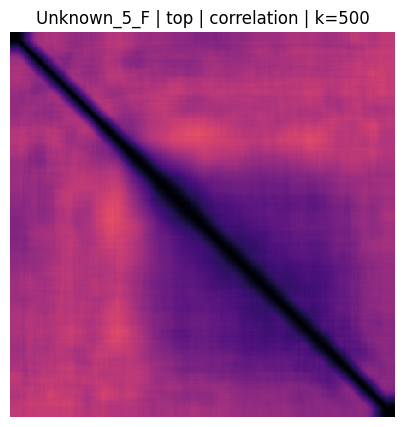

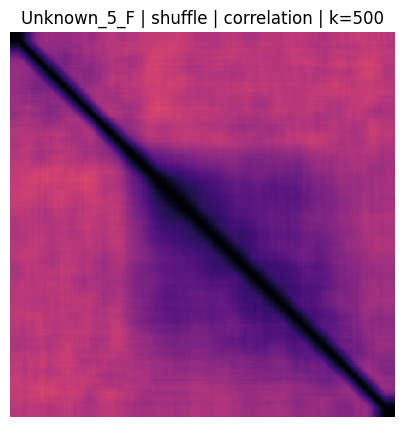

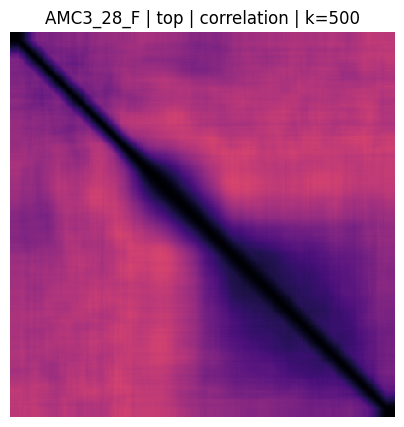

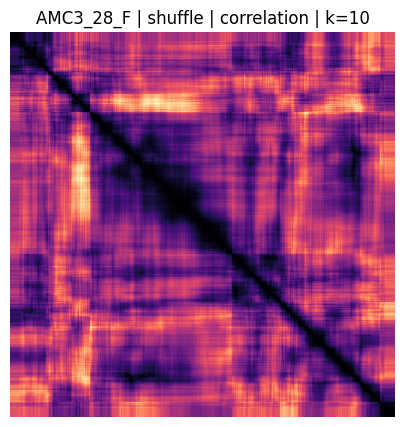

In [57]:
# --- usage ---
# ROI='MF1_7_F'
for ROI in tqdm(rois):
    outpath=f'./{ROI}_timextime_slow.gif'
    out = rdm_gif(dat, ROI, mode='top', step=10, k_max=500, metric='correlation')
    out.save(outpath, writer=PillowWriter(fps=6))
    print("Saved:", ROI)
    
    outpath=f'./{ROI}_shuff_timextime_slow.gif'
    out = rdm_gif(dat, ROI, mode='shuffle', step=10, k_max=500, metric='correlation')
    out.save(outpath, writer=PillowWriter(fps=6))
    print("Saved:", ROI)

In [91]:
# Recompute RDMs per-ROI (top vs shuffled), tile into a 2-row grid animation (no loading GIFs)
import numpy as np, seaborn as sns, matplotlib.pyplot as plt, os
from scipy.spatial.distance import pdist, squareform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image, ImageDraw, ImageFont
import imageio.v2 as iio

def rdm_sequence(dat, ROI, mode='top', step=10, k_max=200, metric='correlation',
                 onset=50, resp=(50,220), base=(-50,0), random_state=0):
    rng = np.random.default_rng(random_state)
    ONSET = onset
    RESP = slice(ONSET + resp[0], ONSET + resp[1])
    BASE = slice(ONSET + base[0], ONSET + base[1])

    sig = dat[dat['p_value'] < 0.05]
    df = sig[sig['roi'] == ROI]
    if len(df) == 0:
        raise ValueError(f"No data for ROI {ROI}")
    X = np.stack(df['img_psth'].to_numpy())          # (units, time, images)

    scores = np.nanmean(X[:, RESP, :], axis=(0,1)) - np.nanmean(X[:, BASE, :], axis=(0,1))
    order = np.argsort(scores)[::-1] if mode == 'top' else rng.permutation(scores.size)

    sizes = [k for k in range(step, min(k_max, X.shape[2]) + 1, step)]
    rdms = []
    for k in sizes:
        idx = order[:k]
        Xavg = np.nanmean(X[:, :, idx], axis=0)      # (time, k)
        R = squareform(pdist(Xavg, metric=metric))   # (time, time)
        rdms.append(R)
    return sizes, rdms

def rdm_to_image(R, vmin, vmax, dpi=120, cmap='magma'):
    fig, ax = plt.subplots(figsize=(3,3), dpi=dpi)
    sns.heatmap(R, ax=ax, cmap=sns.color_palette(cmap, as_cmap=True),
                vmin=vmin, vmax=vmax, square=True, cbar=False,
                xticklabels=False, yticklabels=False)
    ax.set_xlabel(""); ax.set_ylabel(""); fig.tight_layout()
    fig.canvas.draw()
    img = np.asarray(fig.canvas.buffer_rgba())
    plt.close(fig)
    return Image.fromarray(img)

def build_grid_gif(dat, ROI_LIST, step=10, k_max=200, metric='correlation',
                   out_path='rdm_grid.gif', random_state=0):
    # compute sequences for all ROIs (top & shuffle)
    seqs_top, seqs_shuf = {}, {}
    for roi in ROI_LIST:
        sizes, rdms_top = rdm_sequence(dat, roi, mode='top', step=step, k_max=k_max,
                                       metric=metric, random_state=random_state)
        _,     rdms_shf = rdm_sequence(dat, roi, mode='shuffle', step=step, k_max=k_max,
                                       metric=metric, random_state=random_state)
        seqs_top[roi], seqs_shuf[roi] = rdms_top, rdms_shf

    # global color limits for consistency
    vmax = np.nanmax([np.nanmax(R) for v in (*seqs_top.values(), *seqs_shuf.values()) for R in v])
    vmin = 0.0

    T = len(next(iter(seqs_top.values())))  # number of frames (same step schedule)
    frames = []
    for t in range(T):
        top_tiles  = [rdm_to_image(seqs_top[roi][t],  vmin, vmax)  for roi in ROI_LIST]
        shuf_tiles = [rdm_to_image(seqs_shuf[roi][t], vmin, vmax)  for roi in ROI_LIST]
    
        W, H = top_tiles[0].size
        row_top  = Image.new('RGB', (W*len(ROI_LIST), H))
        row_shuf = Image.new('RGB', (W*len(ROI_LIST), H))
        for j, img in enumerate(top_tiles):  row_top.paste(img,  (j*W, 0))
        for j, img in enumerate(shuf_tiles): row_shuf.paste(img, (j*W, 0))
    
        grid = Image.new('RGB', (W*len(ROI_LIST), H*2 + 40), color=(255,255,255))
        grid.paste(row_top, (0, 20))
        grid.paste(row_shuf, (0, H+20))
        draw = ImageDraw.Draw(grid)
    
        # ROI names
        for j, roi in enumerate(ROI_LIST):
            xmid = j*W + W//2
            draw.text((xmid, 10), roi, fill="black", anchor='mt', font_size=18)
    
        # image IDs (the subset size used)
        used_k = sizes[t]
        draw.text((grid.width//2, 2*H+30),
                  f"Images used: top {used_k}",  anchor='mb', fill="black", font_size=18)
    
        frames.append(grid)

    iio.mimsave(out_path, frames, duration=1, loop=0)
    return out_path

In [96]:
# ---- usage ----
ROI_LIST = ['AB3_18_B',
 'MB3_12_B',
 'AB3_12_B',
 'AB3_17_B',]

SAVE_PATH = f'/Users/aim/Desktop/HVRD/workspace/dynamics/gifs/omni_body.gif'
out = build_grid_gif(dat, ROI_LIST, step=10, k_max=750, metric='correlation', out_path=SAVE_PATH)
print("Saved:", out)

Saved: /Users/aim/Desktop/HVRD/workspace/dynamics/gifs/omni_body.gif
